<a href="https://colab.research.google.com/github/manthony-42/ATLAS_UK_NN_TUTORIAL/blob/main/Copy_of_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
first_run = True

In [ ]:
if first_run:
  print('--- INSTALLING PACKAGES ---')
  !python3 -m pip install --upgrade pip
  !python3 -m pip install grpcio==1.32.0
  !python3 -m pip install tensorflow==2.2.0
  !python3 -m pip install keras
  !python3 -m pip install sklearn
  !python3 -m pip install seaborn==0.11.0
  !python3 -m pip install pydot
  !python3 -m pip install graphviz
  !python3 -m pip install uproot4
  !python3 -m pip install awkward1
  !python3 -m pip install progressbar2
else:
  print('--- SKIPPING INSTALL ---')

--- INSTALLING PACKAGES ---
     |████████████████████████████████| 1.5MB 5.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 516.2 MB 18 kB/s 
     |████████████████████████████████| 3.0 MB 47.8 MB/s 
     |████████████████████████████████| 454 kB 47.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 195 kB 6.1 MB/s 
     |███████████████████

In [ ]:
import tensorflow
from keras.optimizers import Adam
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout
# use this if you see interfacing issues relating to TF and Keras
from tensorflow.keras.models import Sequential                    
from tensorflow.keras.layers import Dense, Activation, Dropout

In [ ]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import pydot
import graphviz
import matplotlib.pyplot as plt
import uproot4
import awkward1
import numpy as np
import progressbar

#Now for the Physics part...

In [ ]:
if first_run:
  !rm *.root*
  !wget http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_387163.TT_directTT_600_1.1largeRjet1lep.root
  !wget http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_410000.ttbar_lep.1largeRjet1lep.root
  !ls

rm: cannot remove '*.root*': No such file or directory
--2021-01-05 09:03:55--  http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_387163.TT_directTT_600_1.1largeRjet1lep.root
Resolving opendata.cern.ch (opendata.cern.ch)... 188.185.82.144, 188.184.28.138, 2001:1458:d00:2e::100:34, ...
Connecting to opendata.cern.ch (opendata.cern.ch)|188.185.82.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2578131 (2.5M) [application/octet-stream]
Saving to: ‘mc_387163.TT_directTT_600_1.1largeRjet1lep.root’

mc_387163.TT_direct 100%[===================>]   2.46M  1.29MB/s    in 1.9s    

2021-01-05 09:03:59 (1.29 MB/s) - ‘mc_387163.TT_directTT_600_1.1largeRjet1lep.root’ saved [2578131/2578131]

--2021-01-05 09:03:59--  http://opendata.cern.ch/eos/opendata/atlas/OutreachDatasets/2020-01-22/1largeRjet1lep/MC/mc_410000.ttbar_lep.1largeRjet1lep.root
Resolving opendata.cern.ch (opendata.cern.ch)... 188.185.82.144, 188.184.28.138, 2001:

In [ ]:
stop_file = uproot4.open("mc_387163.TT_directTT_600_1.1largeRjet1lep.root")
top_file = uproot4.open("mc_410000.ttbar_lep.1largeRjet1lep.root")
stop_tree = stop_file['mini']
top_tree = top_file["mini"]

In [ ]:
stop_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
eventNumber          | int32_t                  | AsDtype('>i4')
channelNumber        | int32_t                  | AsDtype('>i4')
mcWeight             | float                    | AsDtype('>f4')
scaleFactor_PILEUP   | float                    | AsDtype('>f4')
scaleFactor_ELE      | float                    | AsDtype('>f4')
scaleFactor_MUON     | float                    | AsDtype('>f4')
scaleFactor_PHOTON   | float                    | AsDtype('>f4')
scaleFactor_TAU      | float                    | AsDtype('>f4')
scaleFactor_BTAG     | float                    | AsDtype('>f4')
scaleFactor_LepTR... | float                    | AsDtype('>f4')
scaleFactor_Photo... | float                    | AsDtype('>f4')
trigE                | bool                     | AsDtype(

In [ ]:
def prepare_dataset( tree ):

  events_limit = 1600

  # Retrieve branches from trees in awkward array
  vars = ['jet_n','met_et','met_phi','jet_pt','jet_phi','jet_eta','lep_n','lep_pt','lep_eta','lep_phi','largeRjet_n','largeRjet_pt','largeRjet_eta','largeRjet_phi']
  cuts = 'jet_n == 4' 
  temp_tree = tree.arrays(vars, cuts)

  # Define branches of variable length to be flattened
  expand_vars = {'jet_pt': 0, 
                 'jet_phi': 0, 
                 'jet_eta': 0, 
                 'largeRjet_pt': 0, 
                 'largeRjet_phi': 0, 
                 'largeRjet_eta': 0,
                 'lep_pt': 0,
                 'lep_phi': 0,
                 'lep_eta': 0 
                 }

  # Prepare dataframe columns
  columns = []
  #for item in vars:
  #  if item in expand_vars.keys():
  #    columns.append('{}_{}'.format(item, expand_vars[item]))
  #  else:
  #    columns.append(item)
  temp_df = pd.DataFrame(columns=vars)

  # Fill dataframe
  for index, entry in progressbar.progressbar(enumerate(temp_tree)):
    for var in vars:
      if var in expand_vars:
        temp_df.at[index, var] = float(entry[var][expand_vars[var]])
      else:
        temp_df.at[index, var] = float(entry[var])
    if index == events_limit:
      break

  for column in temp_df.columns:
    temp_df[column] = pd.to_numeric(temp_df[column])

  return temp_df

In [ ]:
def make_plot( sig, bkg, variable1, variable2='', function='', xlow=0, xhigh=1E6, bins=50, norm=True, log=False ):

  np_bins = np.linspace(xlow, xhigh, bins+1)
  plt.gcf().clear()

  if variable2 == '' and function == '':
    plt.hist( sig[variable1], bins=np_bins, density=norm, label='Sig', histtype='step' )
    plt.hist( bkg[variable1], bins=np_bins, density=norm, label='Bkg', histtype='step' )
    plt.xlabel(variable1)
  else:
    if function == '+':
      plt.hist( sig[variable1]+sig[variable2], bins=np_bins, density=norm, label='Sig', histtype='step' )
      plt.hist( bkg[variable1]+bkg[variable2], bins=np_bins, density=norm, label='Bkg', histtype='step' )
    elif function == '-':
      plt.hist( sig[variable1]-sig[variable2], bins=np_bins, density=norm, label='Sig', histtype='step' )
      plt.hist( bkg[variable1]-bkg[variable2], bins=np_bins, density=norm, label='Bkg', histtype='step' )
    elif function == '*':
      plt.hist( sig[variable1]*sig[variable2], bins=np_bins, density=norm, label='Sig', histtype='step' )
      plt.hist( bkg[variable1]*bkg[variable2], bins=np_bins, density=norm, label='Bkg', histtype='step' )
    elif function == '/':
      plt.hist( sig[variable1]/sig[variable2], bins=np_bins, density=norm, label='Sig', histtype='step' )
      plt.hist( bkg[variable1]/bkg[variable2], bins=np_bins, density=norm, label='Bkg', histtype='step' )
    plt.xlabel('{}{}{}'.format(variable1, function, variable2))
  if log:
    plt.yscale('log')
  plt.grid(False)
  plt.legend(loc='best')
  plt.show()

In [ ]:
stop_df = prepare_dataset(stop_tree)
top_df = prepare_dataset(top_tree)

| |                             #                  | 1499 Elapsed Time: 0:00:02
\ |                               #                | 1581 Elapsed Time: 0:00:03

In [ ]:
def calculate_mt(df):

  df['dphi_l1_met'] = np.abs(df['lep_phi'] - df['met_phi'])
  df['mt'] = np.sqrt(2 * df['lep_pt'] * df['met_et'] * (1-np.cos(df['dphi_l1_met'])))
  return df

In [ ]:
stop_df = calculate_mt(stop_df)
top_df = calculate_mt(top_df)

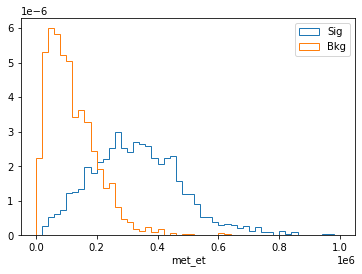

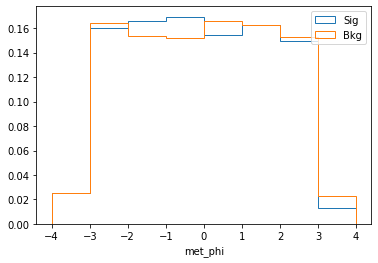

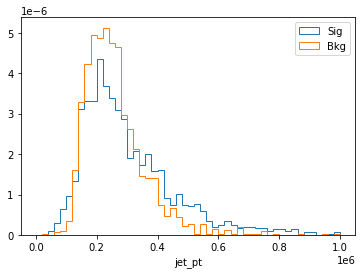

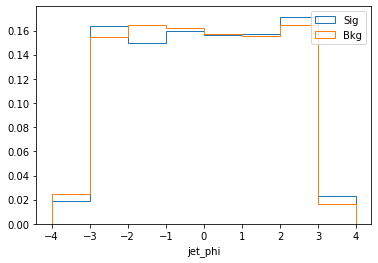

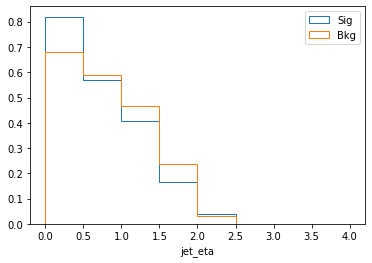

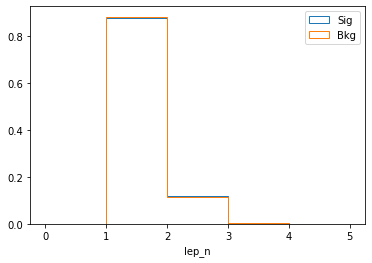

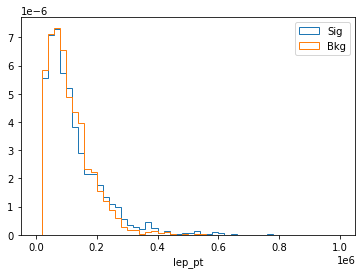

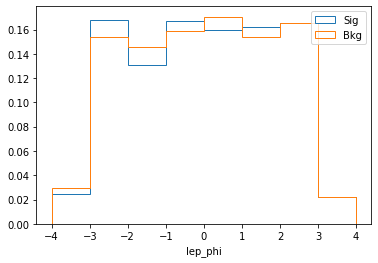

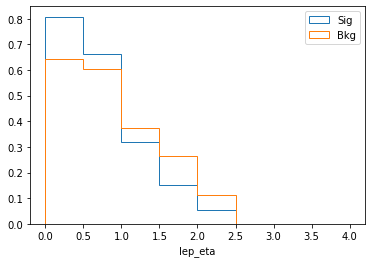

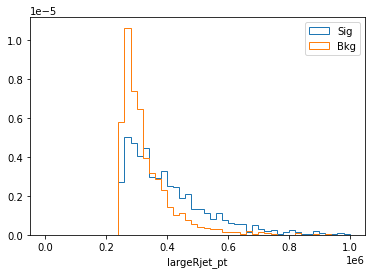

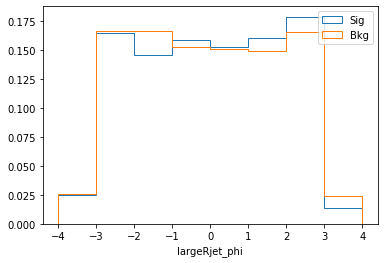

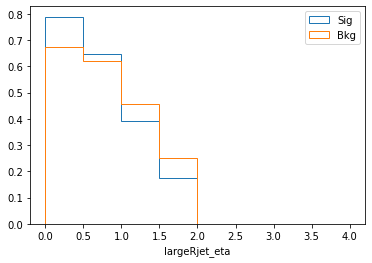

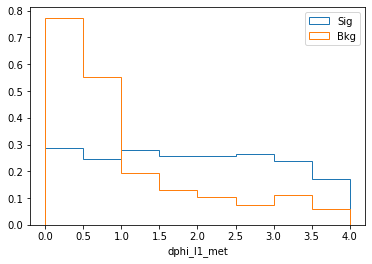

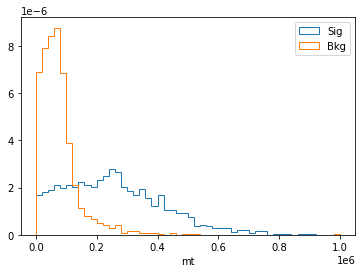

In [ ]:
make_plot(stop_df, top_df, 'met_et')
make_plot(stop_df, top_df, 'met_phi', xlow=-4, xhigh=4, bins=8)

make_plot(stop_df, top_df, 'jet_pt')
make_plot(stop_df, top_df, 'jet_phi', xlow=-4, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'jet_eta', xlow=0, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'lep_n', xlow=0, xhigh=5, bins=5)
make_plot(stop_df, top_df, 'lep_pt')
make_plot(stop_df, top_df, 'lep_phi', xlow=-4, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'lep_eta', xlow=0, xhigh=4, bins=8)

make_plot(stop_df, top_df, 'largeRjet_pt')
make_plot(stop_df, top_df, 'largeRjet_phi', xlow=-4, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'largeRjet_eta', xlow=0, xhigh=4, bins=8)

make_plot(stop_df, top_df, 'dphi_l1_met', xlow=0, xhigh=4, bins=8)
make_plot(stop_df, top_df, 'mt')

In [ ]:
stop_df['class'] = 1
top_df['class'] = 0
merge_df = pd.concat([stop_df, top_df])

X = merge_df.drop(['class'], axis=1)
y = merge_df[['class']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42 )

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#y_train = to_categorical( y_train )
#y_test = to_categorical( y_test )

In [ ]:
def NNmodel():

    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], activation='relu', name='layer_1')) # input layer
    model.add(Dense(10, activation='relu', name='layer_2'))
    model.add(Dense(10, activation='relu', name='layer_3'))
    model.add(Dense(1, activation='sigmoid', name='output_layer')) # 
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
model = NNmodel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
layer_2 (Dense)              (None, 10)                90        
_________________________________________________________________
layer_3 (Dense)              (None, 10)                110       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 11        
Total params: 347
Trainable params: 347
Non-trainable params: 0
_________________________________________________________________
None


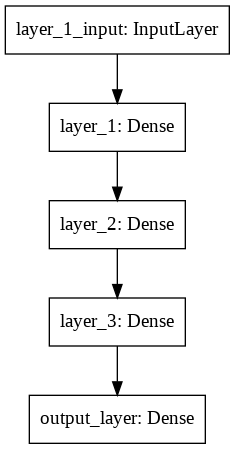

In [ ]:
print( model.summary() )
plot_model( model )

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit( X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stop] )

Epoch 1/200
217/217 - 1s - loss: 0.6538 - accuracy: 0.6737 - val_loss: 0.5878 - val_accuracy: 0.7723
Epoch 2/200
217/217 - 0s - loss: 0.4687 - accuracy: 0.8235 - val_loss: 0.3816 - val_accuracy: 0.8582
Epoch 3/200
217/217 - 0s - loss: 0.3652 - accuracy: 0.8562 - val_loss: 0.3555 - val_accuracy: 0.8475
Epoch 4/200
217/217 - 0s - loss: 0.3440 - accuracy: 0.8654 - val_loss: 0.3430 - val_accuracy: 0.8561
Epoch 5/200
217/217 - 0s - loss: 0.3338 - accuracy: 0.8650 - val_loss: 0.3389 - val_accuracy: 0.8561
Epoch 6/200
217/217 - 0s - loss: 0.3272 - accuracy: 0.8728 - val_loss: 0.3312 - val_accuracy: 0.8614
Epoch 7/200
217/217 - 0s - loss: 0.3253 - accuracy: 0.8742 - val_loss: 0.3341 - val_accuracy: 0.8700
Epoch 8/200
217/217 - 0s - loss: 0.3251 - accuracy: 0.8733 - val_loss: 0.3322 - val_accuracy: 0.8690
Epoch 9/200
217/217 - 0s - loss: 0.3244 - accuracy: 0.8756 - val_loss: 0.3297 - val_accuracy: 0.8679
Epoch 10/200
217/217 - 0s - loss: 0.3217 - accuracy: 0.8714 - val_loss: 0.3560 - val_accura

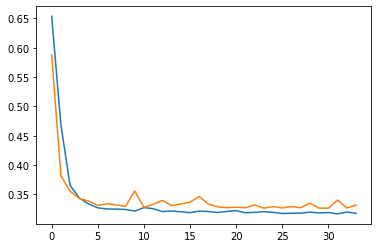

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

In [ ]:
_, training_accuracy = model.evaluate(X_train, y_train)
_, test_accuracy = model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 1ms/step - loss: 0.3320 - accuracy: 0.8647


#Activation functions
 For each neuron, the output it makes will be of the form  Sum(Weight * x) + bias. But, how does one convert this into a more "binary" yes or no statement?
 So in essence this becomes a function 
 $$ Y =f\left(\sum w_i*x_i +b\right).$$
 An initial guess would be a step function (where a neuron was either on/off only).
 But, this becomes problematic when you have several nodes in a network making decisions. A continuum solution is better, so that "on/off" is replaced with "90% on" etc. This is the role of the activation function, and there are several available. Generally the behaviour that is desired is that it is continuous (or at least piecewise continuous) and piecewise differentiable.

 Typically activation functions are plotted on the range [-1,1], and we will discuss a few of these.

 One of the simplest classes of activation function is the linear function
 $Y=cx$ (c non-zero, real), but in such a case, a network consisting of N layers with such a function can be compressed into a single layer with a different constant defined in the activation function. In order to investigate a network with a non-reducible structure, a 

 A more useful case to binary classification (which has a similar behaviour to the step function) is the sigmoid, defined as:

 $$Y=\textrm{sigmoid}(x)=\frac{1}{1+\exp(-x)}$$
 However, the primary issue of the sigmoid function is that for large values of x, the gradient of the activation function is small, which means that the neurons will learn slowly (since the learning process involves minimisation) for large values of x, which is not ideal. 
 
 An alternative to the sigmoid is the tanh(x) function defined on range [-1,1].

 $$Y=\tanh(x)$$

 which is purely a re-scaled sigmoid, when one considers the hyperbolic identity $$\tanh(u)=2\textrm{ sigmoid}(2u)-1 $$
 This function is steeper than the sigmoid across its range of definition, which may improve the speed of learning.

Instead of using the linear activation function, another popular choice of activation function is what is known as "Rectified Linear Units" (ReLU), namely the function: 
$$ Y=max(0,x).$$
Since for nodes with $x < 0$, the neuron is not activated (and is effectively discarded), it can greatly reduce computational time by only activating a small subset of nodes (this behaviour is known as `sparse activation`). 

However, for nodes with $x < 0$, these nodes are effectively "dead" and weights associated to these nodes cannot be updated/cannot "learn".

Some attempts to rectify this include `leaky ReLU`(RelU), typically defined as:
$$Y=\max(ax,x), a = 0.01$$ and exponential linear units (see https://arxiv.org/pdf/1511.07289.pdf)

We will now plot some of these activation functions.



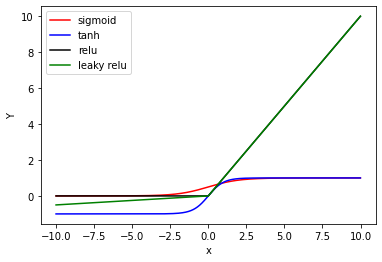

In [ ]:
# typically these will be in tensorflow libraries by default
import numpy as np
def sigmoid(x):
  sigmoid=1/(1+np.exp(-x))
  return sigmoid

def ReLU(x):
  if(x>0):
    return x
  else:
    return 0


def LeakyReLU(x):
  if(x>0):
    return x
  else:
    return 0.05*x # effect exaggerated for plot

def PlotActivations():
  #function to show the activation functions discussed above
  
  import matplotlib.pyplot as plt
  range_array=np.arange(-10.0,10.0,0.01)
  y_sigmoid=[]
  y_tanh=[]
  y_RelU=[]
  y_LRelU=[]
  for x in range_array:
    y_sigmoid.append(sigmoid(x))
    y_tanh.append(np.tanh(x))
    y_RelU.append(ReLU(x))
    y_LRelU.append(LeakyReLU(x))

  plt.plot(range_array,y_sigmoid,color='r',label="sigmoid")
  plt.plot(range_array,y_tanh,color='b',label='tanh')
  plt.plot(range_array,y_RelU,color='k',label='relu')
  plt.plot(range_array,y_LRelU,color='g',label="leaky relu")
  plt.xlabel('x')
  plt.ylabel('Y')
  plt.legend()
  return
PlotActivations()

Now, we try a different NN configuration to the one we chose before:
Replace the activation function for each node in the hidden layers with a sigmoid.

Tensorflow (Keras) has several of these activation functions as built-in modules configured by string. The list of available pre-made functions can be found here
https://www.tensorflow.org/api_docs/python/tf/keras/activations


In [ ]:
def NNmodel_sigmoid(activation_function="sigmoid"):
  model = Sequential()
  model.add(Dense(8, input_dim=X_train.shape[1], activation='relu', name='layer_1')) # input layer
  model.add(Dense(10, activation=activation_function, name='layer_2'))
  model.add(Dense(10, activation=activation_function, name='layer_3'))
  model.add(Dense(1, activation='sigmoid', name='output_layer')) # 
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

model_sigmoid=NNmodel_sigmoid()
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history_sigmoid = model_sigmoid.fit( X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stop] )



Epoch 1/200
217/217 - 0s - loss: 0.6964 - accuracy: 0.4954 - val_loss: 0.6895 - val_accuracy: 0.5102
Epoch 2/200
217/217 - 0s - loss: 0.6815 - accuracy: 0.6018 - val_loss: 0.6693 - val_accuracy: 0.6187
Epoch 3/200
217/217 - 0s - loss: 0.6432 - accuracy: 0.7567 - val_loss: 0.6042 - val_accuracy: 0.7809
Epoch 4/200
217/217 - 0s - loss: 0.5550 - accuracy: 0.8203 - val_loss: 0.4892 - val_accuracy: 0.8582
Epoch 5/200
217/217 - 0s - loss: 0.4567 - accuracy: 0.8433 - val_loss: 0.4018 - val_accuracy: 0.8604
Epoch 6/200
217/217 - 0s - loss: 0.3926 - accuracy: 0.8525 - val_loss: 0.3594 - val_accuracy: 0.8604
Epoch 7/200
217/217 - 0s - loss: 0.3608 - accuracy: 0.8604 - val_loss: 0.3410 - val_accuracy: 0.8668
Epoch 8/200
217/217 - 0s - loss: 0.3480 - accuracy: 0.8664 - val_loss: 0.3358 - val_accuracy: 0.8679
Epoch 9/200
217/217 - 0s - loss: 0.3391 - accuracy: 0.8659 - val_loss: 0.3349 - val_accuracy: 0.8593
Epoch 10/200
217/217 - 0s - loss: 0.3330 - accuracy: 0.8673 - val_loss: 0.3276 - val_accura

Now plot the loss as a function of epoch for the training set, comparing to the previously configured model

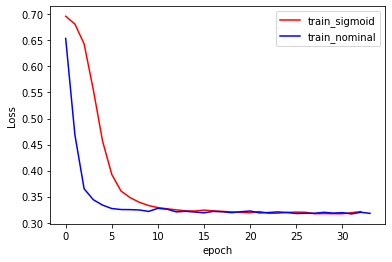

In [ ]:
plt.plot(history_sigmoid.history['loss'], label='train_sigmoid',color="r")
plt.plot(history.history['loss'], label='train_nominal',color='b')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()

And similarly for the validation loss as a function of epoch

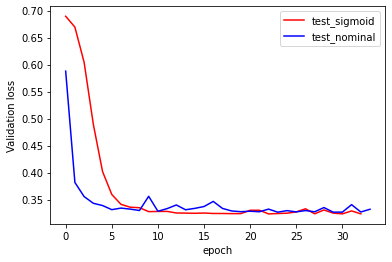

In [ ]:
plt.plot(history_sigmoid.history["val_loss"],label='test_sigmoid',color='r')
plt.plot(history.history["val_loss"],label='test_nominal',color='b')
plt.xlabel('epoch')
plt.ylabel('Validation loss')
plt.legend()

And the accuracy as a function of epoch

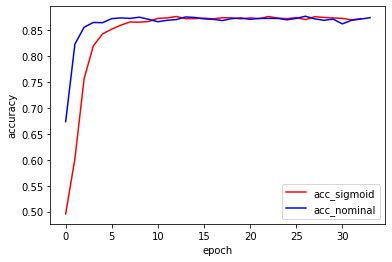

In [ ]:
plt.plot(history_sigmoid.history['accuracy'],label='acc_sigmoid',color='r')
plt.plot(history.history['accuracy'],label='acc_nominal',color='b')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

As you can see, the effect of using ReLU for the hidden layers is that the NN learns faster than that of the NN configured with a sigmoid in the activation function, taking advantage of the sparse activation discussed above, with similar overall performance.

In a real physics use case on large datasets, the CPU/GPU processing time is a major overhead that one must consider when implementing a NN, so fewer epochs to converge = faster.

However, there is no preferred choice of activation functions in a NN, so one must attempt with trial and error.

# Useful parameters to configure: Learning rate
NNs involve configuration of the learning rate (extent to which weights are updated after each back-propagation step/epoch), which is typically taken to be in the range $(0.0,1.0)$. The learning rate determines the speed at which the model "learns", such that the larger the learning rate, the faster the model learns at the cost of a somewhat sub-optimal set of parameters and the converse case for the small learning rate.

However, if the learning rates are too large, the weight updates will be too large and will oscillate over training epochs. Conversely if the learning rates are too small, a model may converge to a sub-optimal set of weights.

The Tensorflow default for this parameter is `LR=0.01`, and we will vary this parameter to `LR=0.02` to demonstrate the impact of this parameter.

The exact choice for your use case must be determined by trial and error.

In [ ]:
def NNmodel_altLR(activation_function="relu"):
  model = Sequential()
  model.add(Dense(8, input_dim=X_train.shape[1], activation='relu', name='layer_1')) # input layer
  model.add(Dense(10, activation=activation_function, name='layer_2'))
  model.add(Dense(10, activation=activation_function, name='layer_3'))
  model.add(Dense(1, activation='sigmoid', name='output_layer')) 
  #configure the optimiser. This is where the learning rate is configured
  learningrate=0.02
  opt=Adam(learning_rate=learningrate)
  # can now pass the optimizer we just defined into the model
  model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
  return model,learningrate

NNmodel_altLR,learningrate=NNmodel_altLR()

early_stop = EarlyStopping(monitor='val_loss', patience=10)
history_altLR = NNmodel_altLR.fit( X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stop] )



Epoch 1/200
217/217 - 0s - loss: 0.4250 - accuracy: 0.8120 - val_loss: 0.3404 - val_accuracy: 0.8593
Epoch 2/200
217/217 - 0s - loss: 0.3533 - accuracy: 0.8502 - val_loss: 0.3690 - val_accuracy: 0.8582
Epoch 3/200
217/217 - 0s - loss: 0.3647 - accuracy: 0.8507 - val_loss: 0.3394 - val_accuracy: 0.8690
Epoch 4/200
217/217 - 0s - loss: 0.3339 - accuracy: 0.8576 - val_loss: 0.3301 - val_accuracy: 0.8690
Epoch 5/200
217/217 - 0s - loss: 0.3388 - accuracy: 0.8590 - val_loss: 0.3549 - val_accuracy: 0.8604
Epoch 6/200
217/217 - 0s - loss: 0.3341 - accuracy: 0.8613 - val_loss: 0.3609 - val_accuracy: 0.8539
Epoch 7/200
217/217 - 0s - loss: 0.3325 - accuracy: 0.8613 - val_loss: 0.3534 - val_accuracy: 0.8690
Epoch 8/200
217/217 - 1s - loss: 0.3387 - accuracy: 0.8585 - val_loss: 0.3386 - val_accuracy: 0.8690
Epoch 9/200
217/217 - 0s - loss: 0.3331 - accuracy: 0.8636 - val_loss: 0.3298 - val_accuracy: 0.8700
Epoch 10/200
217/217 - 0s - loss: 0.3281 - accuracy: 0.8659 - val_loss: 0.3318 - val_accura

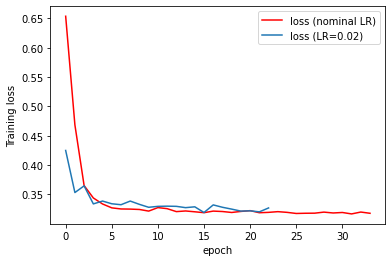

In [ ]:
plt.plot(history.history['loss'],label='loss (nominal LR)',color='r')
plt.plot(history_altLR.history['loss'],label='loss (LR={})'.format(learningrate))
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.legend()

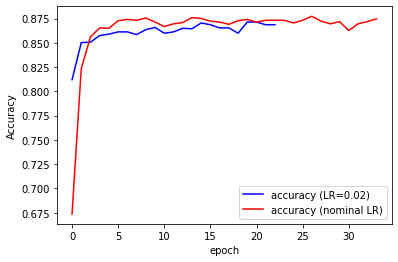

In [ ]:
plt.plot(history_altLR.history["accuracy"],label='accuracy (LR={})'.format(learningrate),color='b')
plt.plot(history.history['accuracy'],label='accuracy (nominal LR)',color='r')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

Extension exercise:

Use the results of previous tasks to configure the DNN with different input variables, learning rates and activation functions for hidden/output nodes to produce the best classification.